<a href="https://colab.research.google.com/github/jaotheboss/ESG-Disclosure-Analysis/blob/preprocessing-tweaks/Main_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Analysis for DSA4264

**Task**:
Explore the relationship between a firm's environmental disclosure and financial performance. 


**Tasks**:
1. Extract out the text data of the firms that have available financial metrics
2. Filter out the environmental disclosures (sentence that contains the keywords or n-grams) from the text data
3. Concatenate all the sentences from each document and have each document form the observations of a corpus
4. Perform LDA or STM on the corpus
5. Analyse the results:
    
    - Between rating 1 and 5
    - Across the years
    - Both

## Setting up the modules and functions

In [1]:
# setting up the work directory
import os 
os.chdir('/content/drive/My Drive/School/NUS/Year 4 Sem 1/DSA4264/(TSX) Toronto')

!pip install pyLDAvis
!pip install pdfplumber

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation # LDA
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.sklearn
import pdfplumber
import multiprocessing as mp

     |████████████████████████████████| 1.6MB 6.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=cf4b5260f5d9f002fb9a158eecf8b1d3a73b2cf31a1c05b32442e2dd045ff677
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 5.6MB 10.6MB/s 
     |████████████████████████████████| 143kB 48.2MB/s 
     |████████████████████████████████| 13.7MB 318kB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.5.24-cp36-none-any.whl size=31125 sha256=ca2b47d046d4893bcab03a507ad5693a4ea0054ac8dd3df11405488e6116fcba
  Stored in directory: /root/.cache/pip/wheels/42/e7/9d/783e40e447a240ace74b520158a133175853f3c3b2999f4520
Successfully built pdfplumber


In [100]:
# defining functions
def _PREPROCESS(text, min_char_len = 3, max_char_len = 15):
    """
    Function:     Preprocesses and cleans text
                    
    Input:        Text array
    
    Returns:      A column of processed text
    """
    contractions = {
            "ain't": "am not / are not",
            "aren't": "are not / am not",
            "can't": "cannot",
            "can't've": "cannot have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he had / he would",
            "he'd've": "he would have",
            "he'll": "he shall / he will",
            "he'll've": "he shall have / he will have",
            "he's": "he has / he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how has / how is",
            "i'd": "I had / I would",
            "i'd've": "I would have",
            "i'll": "I shall / I will",
            "i'll've": "I shall have / I will have",
            "i'm": "I am",
            "i've": "I have",
            "isn't": "is not",
            "it'd": "it had / it would",
            "it'd've": "it would have",
            "it'll": "it shall / it will",
            "it'll've": "it shall have / it will have",
            "it's": "it has / it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she had / she would",
            "she'd've": "she would have",
            "she'll": "she shall / she will",
            "she'll've": "she shall have / she will have",
            "she's": "she has / she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as / so is",
            "that'd": "that would / that had",
            "that'd've": "that would have",
            "that's": "that has / that is",
            "there'd": "there had / there would",
            "there'd've": "there would have",
            "there's": "there has / there is",
            "they'd": "they had / they would",
            "they'd've": "they would have",
            "they'll": "they shall / they will",
            "they'll've": "they shall have / they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we had / we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what shall / what will",
            "what'll've": "what shall have / what will have",
            "what're": "what are",
            "what's": "what has / what is",
            "what've": "what have",
            "when's": "when has / when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where has / where is",
            "where've": "where have",
            "who'll": "who shall / who will",
            "who'll've": "who shall have / who will have",
            "who's": "who has / who is",
            "who've": "who have",
            "why's": "why has / why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you had / you would",
            "you'd've": "you would have",
            "you'll": "you shall / you will",
            "you'll've": "you shall have / you will have",
            "you're": "you are",
            "you've": "you have"}

    def contract(text):
        for word in text.split():
            if word.lower() in contractions:
                text = text.replace(word, contractions[word.lower()])
        return text
    
    def preprocess(text):
        # throw away numbers
        text = re.sub(r"@\S+|https?:\S+|http?:\S|[^A-Za-z]+", ' ', str(text).lower()).strip() 
        doc = nlp(text)
        text = [token.lemma_ for token in doc if token.is_stop == False and len(token) >= min_char_len and len(token) <= max_char_len]
        new_text = ' '.join(text)
        return new_text
       
    text = text.apply(contract).apply(preprocess)
    return text

def extract_pdf_text(file_name, min_sent_len = 10):
    doc = []
    try:
        with pdfplumber.open(file_name) as pdf:
            pages = pdf.pages
            for i in pages:
                page = i.extract_text()
                if page:
                    doc.extend([sentence.string for sentence in nlp(page).sents if len(sentence.text.split()) >= min_sent_len])
    except:
        doc.extend(['Unrecognized PDF!!!'])
    doc = _PREPROCESS(pd.Series(doc))
    return doc

def get_top_k(df, vectorizer, k = 10):
       """get top k occuring words"""
       vectorizer.fit(df)
       counts = pd.DataFrame(vectorizer.transform(df).toarray())
       counts.columns = vectorizer.get_feature_names()
       counts = counts.apply(sum).sort_values(ascending = False)[:k]
       sns.barplot(x = counts.values, y = counts.index)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

## Preprocessing

In [3]:
# getting the file names
metadata = pd.read_csv('clustered_files_cleaned.csv')
def quantiles(arr):
    result = []
    quads = [np.quantile(arr, 0.25*i) for i in range(1, 4)]
    for i in arr:
        if i <= quads[0]:
            result.append(1)
        elif i <= quads[1]:
            result.append(2)
        elif i <= quads[2]:
            result.append(3)
        else:
            result.append(4)
    return result
metadata['rating_quarters'] = quantiles(metadata.earnings)

We will only be looking at the top and bottom 25% of the ratings. This is ensure that there is a discernible distinction in performance metric. By doing so, we hope to more clearly distinguish the aspects of an environmental disclosure that correlates with the financial metric

In [4]:
# filtering out by quarters
filtered_metadata = metadata[['finalfilename', 'fileyear', 'rating_quarters']]
filtered_metadata = filtered_metadata.loc[metadata.rating_quarters != 2, :]  
filtered_metadata = filtered_metadata.loc[metadata.rating_quarters != 3, :]
filtered_metadata.reset_index(drop = True, inplace = True)
filtered_metadata

,finalfilename,fileyear,rating_quarters
0,TSX_7376__Absolute Software Corp___Active____(...,2018,4
1,TSX_7319__AcuityAds Holdings Inc___Active____(...,2018,1
2,TSX_1041__Alacer Gold Corp___Active____(2018-1...,2018,4
3,TSX_1041__Alexco Resource Corp___Active____(20...,2018,1
4,TSX_4449__Algoma Central Corp___Active____(201...,2018,1
...,...,...,...
236,TSX_3533__Total Energy Services Inc___Active__...,2015,4
237,TSX_1031__Trevali Mining Corp___Active____(201...,2015,4
238,TSX_6531__Wall Financial Corp___Active____(201...,2015,4
239,TSX_1021__Wallbridge Mining Company Ltd___Acti...,2015,4


In [5]:
# extracting out the text data
pool = mp.Pool()
dirty_corpus = list(tqdm(pool.imap(extract_pdf_text, filtered_metadata.finalfilename), total = filtered_metadata.finalfilename.size))
pool.close()

100%|██████████| 241/241 [1:31:26<00:00, 22.76s/it]


In [6]:
# filtering the corpus with environmental keywords
# https://quantaloop.io/the-language-of-sustainability-top-101-green-initiative-keywords/
e_sus_keywords = {'global', 'warming', 'water', 
                  'air', 'environmental', 'nature',
                  'earth', 'solar', 'energy',
                  'green', 'recycling', 'pollution',
                  'energy', 'sustain'}
def filter_keyword(dirty_doc):
    filtered_doc = []
    for sentence in dirty_doc:
        # ignore short sentences
        if len(sentence.split()) <= 3:
            continue
        else:
            if e_sus_keywords.intersection(set(sentence.split())):
                filtered_doc.append(sentence)
                break
    return ' '.join(filtered_doc)
pool = mp.Pool()
filtered_corpus = list(tqdm(pool.imap(filter_keyword, dirty_corpus), total = len(dirty_corpus)))
pool.close()

100%|██████████| 241/241 [00:00<00:00, 795.60it/s]


In [63]:
# creating the filtered data file
filtered_data = filtered_metadata.copy()
filtered_data['text'] = filtered_corpus.text
filtered_data = filtered_data[['text', 'fileyear', 'rating_quarters']]
filtered_data = filtered_data.dropna()

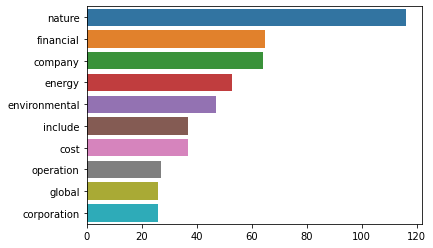

In [65]:
# filtering out the jargon
word2remove = [
               'consolidated', 'asset', 'assets',
               'libaility', 'liabilities', 'organization',
               'statement', 'ltd', 'cid',
               'keyera'
]

final_text = filtered_data.text.apply(lambda x: re.sub(' +', ' ', re.sub('|'.join(word2remove), '', x)).strip())

maxdf, mindf = 0.99, 0.01 # default: 1.0 and 1 
count_vectorizer = CountVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
get_top_k(final_text, count_vectorizer)

In [66]:
# finalizing the text data 
filtered_data.text = final_text
filtered_data

,text,fileyear,rating_quarters
0,nature operation absolute software corporation...,2018,4
1,remain financial assess collectively base nature,2018,1
2,retirement obligation incur decommissioning re...,2018,4
3,environmental services contract loss provision,2018,1
4,global short sea shipping segment include comp...,2018,1
...,...,...,...
236,total energy services inc total energy company...,2015,4
237,provision environmental rehabilitation defer i...,2015,4
238,carry value company amount receivable deposit ...,2015,4
239,total equity nature operation go concern note ...,2015,4


## Performing LDA

To extract topics from each document within the corpus

### Full Dataset

We want to try topic modelling on the full dataset first to see if there are distinct topics within these environmental disclosures

In [89]:
# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(filtered_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=69, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [90]:
# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.062838  0.079098       1        1  23.237812
1      0.028181 -0.037361       2        1  22.104428
4     -0.106936  0.019601       3        1  21.079798
2     -0.009044  0.008541       4        1  17.201351
0      0.024961 -0.069879       5        1  16.376611, topic_info=             Term      Freq     Total Category  logprob  loglift
486          look  2.000000  2.000000  Default  30.0000  30.0000
357       forward  2.000000  2.000000  Default  29.0000  29.0000
358  forward look  2.000000  2.000000  Default  28.0000  28.0000
657     provision  3.000000  3.000000  Default  27.0000  27.0000
809   uncertainty  2.000000  2.000000  Default  26.0000  26.0000
..            ...       ...       ...      ...      ...      ...
606        permit  0.662450  1.789529   Topic5  -5.4534   0.8156
521        nature  0.977703  6.343775   Topic5  -5.0641  -0.0607
499        market  0.658054  1.944678   Topic5  -5.4600   0.7258
686    regulatory  0.634138  1.665040   Topic5  -5.4970   0.8440
138       company  0.634086  5.887817   Topic5  -5.4971  -0.4191

[260 rows x 6 columns], token_table=      Topic      Freq                       Term
term                                            
0         1  0.616007                    ability
26        2  0.768449                acquisition
31        2  0.945302                   addition
32        4  1.007697                  agreement
45        5  0.953564  application environmental
...     ...       ...                        ...
825       2  0.783775           value short term
829       1  0.874492                      water
833       2  0.327667                       year
833       4  0.327667                       year
834       4  0.652580                   year end

[247 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 3, 1])

In [91]:
# Showing the words for each topic
n_words_to_show = 8
display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
financial recognition initial recognition environmental time initial nature determine

Topic 1:
company nature global financial year business exploration value

Topic 2:
operation claim concern go go concern contract nature operation go operation go concern

Topic 3:
provision water environmental segment production rehabilitation environmental rehabilitation end

Topic 4:
energy corporation look forward forward look risk uncertainty risk uncertainty



### Trying on rating 1 and 4

**Rating 1**

In [94]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.rating_quarters == 1, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.065274 -0.000615       1        1  22.118401
0     -0.022360 -0.048827       2        1  20.837682
1     -0.013075  0.040866       3        1  19.985546
4     -0.002273 -0.011105       4        1  18.560726
3     -0.027565  0.019681       5        1  18.497645, topic_info=              Term      Freq     Total Category  logprob  loglift
655      provision  1.000000  1.000000  Default  30.0000  30.0000
361         global  1.000000  1.000000  Default  29.0000  29.0000
87        business  1.000000  1.000000  Default  28.0000  28.0000
321      financial  2.000000  2.000000  Default  27.0000  27.0000
410       inherent  0.000000  0.000000  Default  26.0000  26.0000
..             ...       ...       ...      ...      ...      ...
189           cost  0.379544  1.282725   Topic5  -5.5377   0.4698
385        include  0.356576  1.299138   Topic5  -5.6001   0.3946
352           fund  0.345522  1.093962   Topic5  -5.6316   0.5350
424  international  0.341410  0.858994   Topic5  -5.6435   0.7648
728           sale  0.342203  1.218274   Topic5  -5.6412   0.4177

[251 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
87        5  0.695971                      business
133       3  0.575063                       company
198       1  1.195734                        credit
211       1  0.698960                      december
241       1  0.752660                           end
242       1  1.154025                  end december
250       2  0.621439                        energy
266       2  0.536690                 environmental
270       2  1.186779  environmental rehabilitation
275       3  1.050726                        equity
321       3  0.492614                     financial
321       4  0.492614                     financial
361       3  0.568113                        global
361       5  0.568113                        global
382       3  0.854733                           inc
410       2  1.003408                      inherent
435       1  1.136849                          item
494       1  1.005318                         month
495       1  1.005318                     month end
498       1  0.394233                        nature
498       4  0.394233                        nature
564       5  0.771500                     operation
644       3  0.896969                       project
655       2  0.763763                     provision
688       2  1.186779                rehabilitation
711       2  1.102897                       require
840       2  0.857512                   uncertainty
850       4  1.038638                         value
864       3  0.844660                          year, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

In [95]:
# Showing the words for each topic
n_words_to_show = 8
display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
provision inherent environmental uncertainty require energy rehabilitation environmental rehabilitation

Topic 1:
global financial equity inc year company project december

Topic 2:
end nature december month month end end december credit item

Topic 3:
business global operation ongoing corporation continue oil energy

Topic 4:
nature financial value fair fair value contract base intend



**Rating 4**

In [96]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.rating_quarters == 4, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.062633 -0.010442       1        1  26.481371
3      0.005930  0.056772       2        1  23.777517
4      0.013547 -0.016883       3        1  17.452098
0      0.031651 -0.021004       4        1  16.163684
1      0.011505 -0.008444       5        1  16.125330, topic_info=               Term      Freq     Total Category  logprob  loglift
485          keyera  1.000000  1.000000  Default  30.0000  30.0000
786            risk  1.000000  1.000000  Default  29.0000  29.0000
535            look  0.000000  0.000000  Default  28.0000  28.0000
369    forward look  0.000000  0.000000  Default  27.0000  27.0000
368         forward  0.000000  0.000000  Default  26.0000  26.0000
..              ...       ...       ...      ...      ...      ...
386    global dairy  0.185053  0.605462   Topic5  -6.1446   0.6394
678          permit  0.204761  0.899422   Topic5  -6.0434   0.3449
752  rehabilitation  0.218156  1.099124   Topic5  -5.9800   0.2077
518       liability  0.215344  1.080541   Topic5  -5.9930   0.2118
385          global  0.221302  1.309971   Topic5  -5.9657   0.0465

[271 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
0         2  1.269542               ability
64        2  1.053568            assumption
153       1  0.445423               company
153       2  0.445423               company
153       3  0.445423               company
178       1  1.206357               concern
254       1  0.991194           development
285       1  0.467063                energy
285       2  0.467063                energy
300       2  0.544064         environmental
333       1  0.913897           exploration
350       2  0.594481             financial
368       2  1.003137               forward
369       2  1.003137          forward look
377       2  0.925603                future
389       1  1.206357                    go
390       1  1.206357            go concern
434       2  0.800068               include
453       1  1.156272              industry
459       2  1.231194              inherent
485       4  0.987799                keyera
535       2  1.003137                  look
575       1  0.440170                nature
575       2  0.440170                nature
592       1  1.206357   nature operation go
644       1  0.736401             operation
649       1  1.206357          operation go
650       1  1.206357  operation go concern
713       1  0.862875            production
719       1  1.282779               provide
786       2  0.949280                  risk
787       2  1.236186      risk uncertainty
807       1  0.980937               service
859       2  1.095150               subject
889       1  1.002495                 total
907       2  1.236186           uncertainty
939       1  0.766810                  year, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

In [101]:
# Showing the words for each topic
n_words_to_show = 8
display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
keyera, energy, rehabilitation, rimbey, keyera energy, environmental, provision, opinion

Topic 1:
environmental, expect, strong, saputo, base, plan, benefit, condition

Topic 2:
energy, company, production, year, total, service, exploration, operation

Topic 3:
nature, risk, financial, environmental, forward, look, forward look, company

Topic 4:
company, value, result, nature, liability, corporation, incorporate, british



### Trying on the different years

### Trying on the rating and the years